In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import *
import time
import ott

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from entot.models.utils import MLP, MLP_FM

from ott.solvers.nn.models import ModelBase, NeuralTrainState
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
import pandas as pd
from entot.plotting.plots import plot_1D_unbalanced_new
from entot.models.utils import Simple_MLP
from entot.models.gen_model import OTFlowMatching, MLP_no_noise, OriginalFlowMatching, Bridge_MLP, MLP_FM_VAE2, Simple_MLP2

2023-07-24 19:02:39.195611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from entot.models.utils import MixtureNormalSampler

source = MixtureNormalSampler([-1,0.0,2.0], 1,  0.1, batch_size=512)(jax.random.PRNGKey(0))
target = MixtureNormalSampler([0.0], 1,  0.2, batch_size=512)(jax.random.PRNGKey(0))

<Axes: ylabel='Density'>

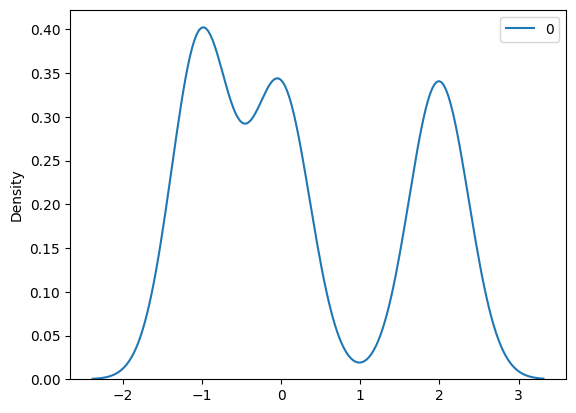

In [6]:
sns.kdeplot(source)

<Axes: ylabel='Density'>

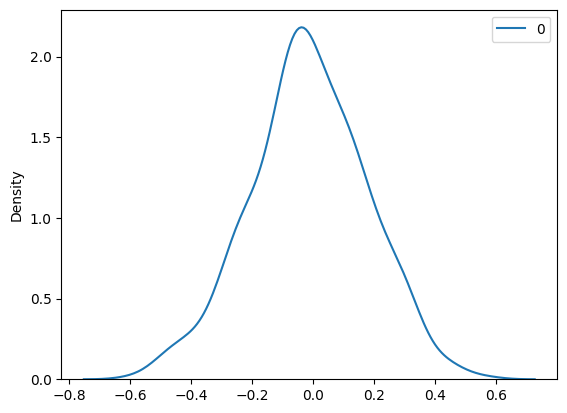

In [7]:
sns.kdeplot(target)

In [8]:
#neural_net = MLP_FM3(1, 32, 32, 32, n_frequencies=10)
#neural_net = MLP_FM(1, [64, 64, 64, 64], n_frequencies=1)
neural_net = MLP_FM_VAE2(1, 64, 64, 64)
bridge_net = Bridge_MLP(1, 16, 16)

In [9]:
#cosine_decay_scheduler = optax.cosine_decay_schedule(1e-3, decay_steps=1_000, alpha=0.95)
#optimizer = optax.adamw(learning_rate=cosine_decay_scheduler)
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()

solver_latent_to_data = None #ott.solvers.linear.sinkhorn.Sinkhorn()
mlp_eta = Simple_MLP2(1, 64)
mlp_xi = Simple_MLP2(1, 64)

otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, tau_a=0.9, tau_b=0.9, mlp_eta=mlp_eta, mlp_xi=mlp_xi, epsilon=1e-2, input_dim=1, output_dim=1, iterations=1_000, noise_std=1.0, k_noise_per_x=10, solver_latent_to_data=solver_latent_to_data)

In [10]:
otfm.iterations=2_000
otfm(source, target, 1024, 1024)

2023-07-24 19:03:02.725628: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
100%|██████████| 2000/2000 [00:23<00:00, 84.92it/s] 


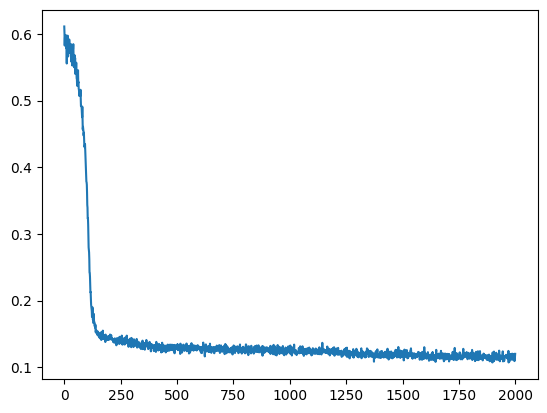

In [11]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

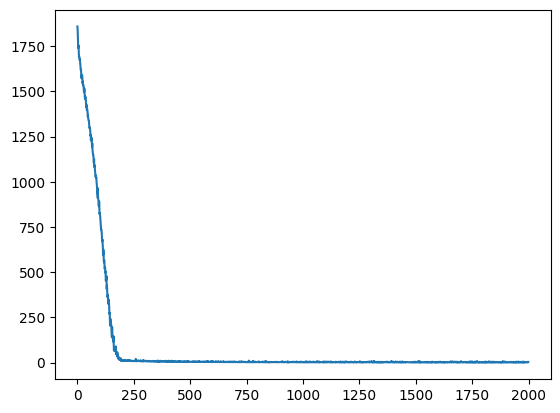

In [12]:
plt.plot(np.arange(len(otfm.metrics["loss_eta"])), otfm.metrics["loss_eta"])

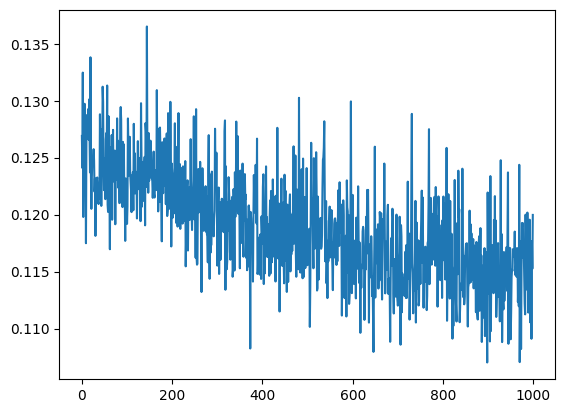

In [13]:
plt.plot(np.arange(len(otfm.metrics["loss"][1000:])), otfm.metrics["loss"][1000:])

In [14]:
res, _, rescale_factor = otfm.transport(source, seed=1, diffeqsolve_kwargs={"max_steps": 1_000_000})

In [15]:
source_sorted = jnp.sort(source, axis=0)

In [16]:
r =otfm.state_bridge_net.apply_fn({"params": otfm.state_bridge_net.params}, condition=source_sorted)

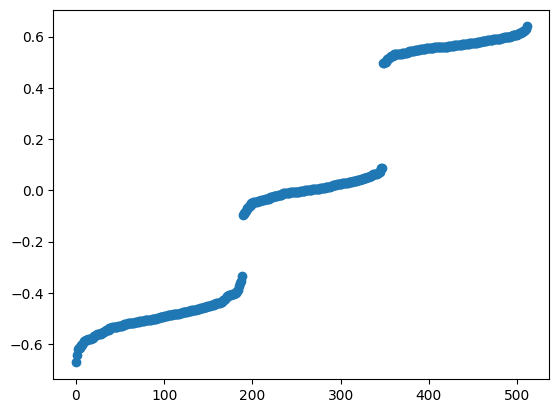

In [17]:
plt.scatter(np.arange(len(r)), r)

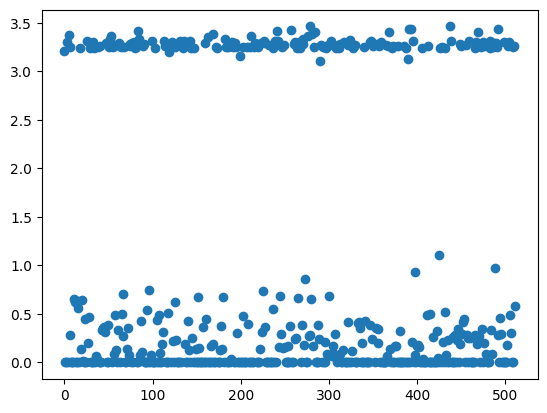

In [18]:
plt.scatter(np.arange(len(rescale_factor)), rescale_factor)

<Axes: ylabel='Density'>

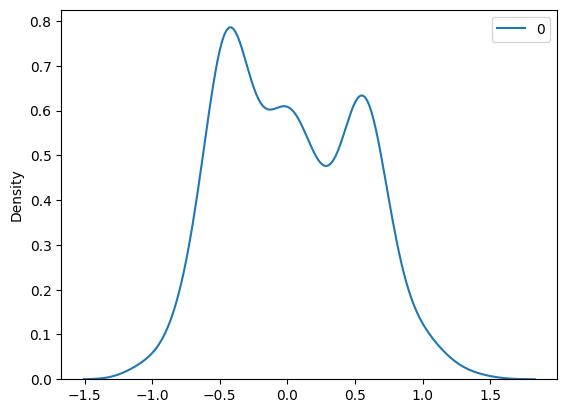

In [19]:
sns.kdeplot(res[0,...])

In [20]:
res.shape

(1, 512, 1)

In [1]:
kwargs = {}
a = (-4.0, 4.0)
b = (0.0, 5.0)
c = (0.0, 4.0)
d = (-1.0, 1.0)
kwargs["00_xlim"] = a
kwargs["01_xlim"] = a
kwargs["02_xlim"] = a
kwargs["03_xlim"] = b
kwargs["04_xlim"] = b
kwargs["10_xlim"] = a
kwargs["11_xlim"] = a
kwargs["12_xlim"] = b
kwargs["13_xlim"] = b
kwargs["14_xlim"] = b

kwargs["00_ylim"] = c
kwargs["01_ylim"] = c
kwargs["02_ylim"] = c
kwargs["03_ylim"] = d
kwargs["04_ylim"] = d
kwargs["10_ylim"] = d
kwargs["11_ylim"] = d
kwargs["12_ylim"] = d
kwargs["13_ylim"] = d
kwargs["14_ylim"] = d

kwargs["bw_adjust"] = 0.8

rescale_source = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, source)
rescale_target = otfm.state_xi.apply_fn({"params": otfm.state_xi.params}, target)

_  = plot_1D_unbalanced_new(source, target, res[0,...], rescale_source, rescale_target, 1e-2, 0.9, 0.9, **kwargs)

NameError: name 'otfm' is not defined

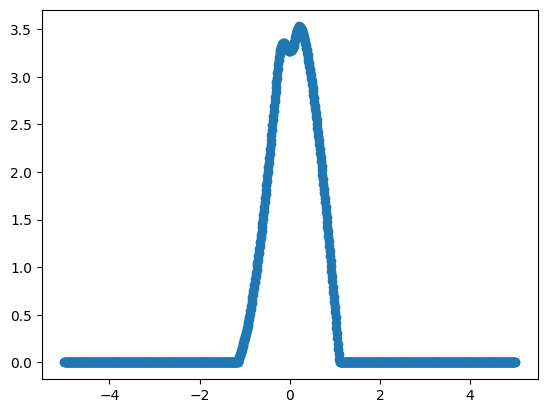

In [52]:
x = jnp.linspace(-5, 5, num=1000)[:, None]
gr = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, x)
plt.scatter(x, gr)

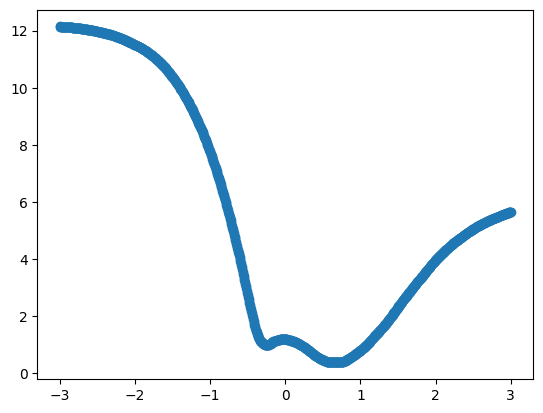

In [53]:
x = jnp.linspace(-3, 3, num=1000)[:, None]
gr = otfm.state_xi.apply_fn({"params": otfm.state_xi.params}, x)
plt.scatter(x, gr)

In [22]:
source_repeat = jnp.ones((1,)) * 0.0
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const, _ = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

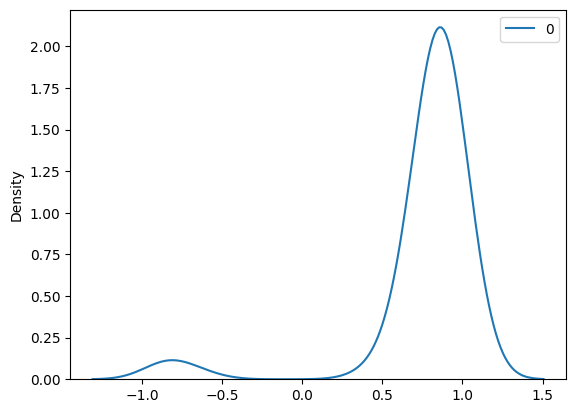

In [23]:
sns.kdeplot(res_const[0,...])

In [24]:
from functools import partial

ts = np.linspace(0,1,300)
saveat=diffrax.SaveAt(ts=ts)

res, sol = otfm.transport(source, seed=0, diffeqsolve_kwargs={"saveat": saveat})

In [25]:
inds = jax.random.choice(jax.random.PRNGKey(0), jnp.arange(len(sol.ys)), (30,))
tracks = sol.ys[:,inds,0]

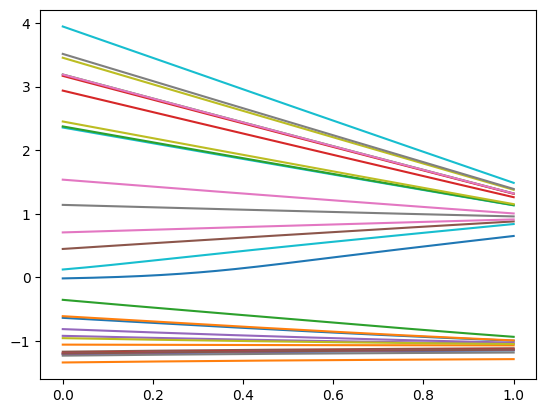

In [26]:
plt.plot(ts, tracks)
plt.show()

In [27]:
t_vec = ts[1:] - ts[:-1]
t_vector = np.tile(t_vec[:, None], (1, tracks.shape[-1]))
y_vector = tracks[1:, ...] - tracks[:-1,...]
t_augmented = np.tile(ts[:, None], (1, tracks.shape[-1]))[:-1, ...]

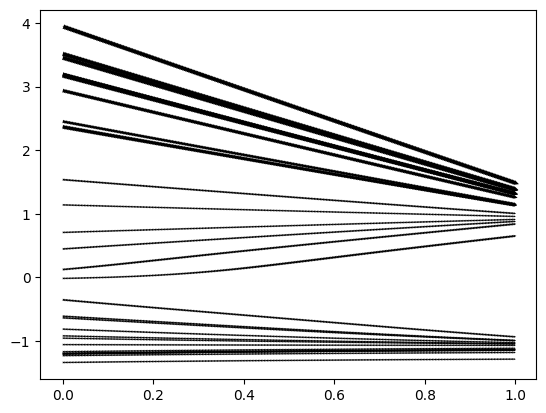

In [28]:
plt.quiver(t_augmented, tracks[:-1], t_vector, y_vector, width=1e-3, headwidth=10, headlength=10, headaxislength=10, angles="xy")

In [29]:
res, sol = otfm.transport(source_repeat, seed=0, diffeqsolve_kwargs={"saveat": saveat})

In [32]:
inds = jax.random.choice(jax.random.PRNGKey(0), jnp.arange(len(sol.ys)), (60,))
tracks = sol.ys[:,inds,0]

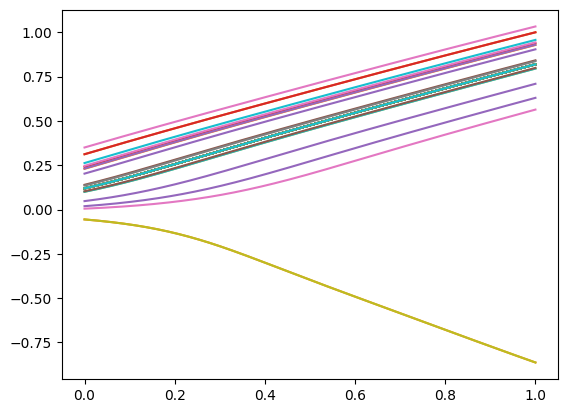

In [33]:
plt.plot(ts, tracks)
plt.show()

In [328]:
ofm(source, target, 64, 64)

100%|██████████| 1000/1000 [00:05<00:00, 186.10it/s]


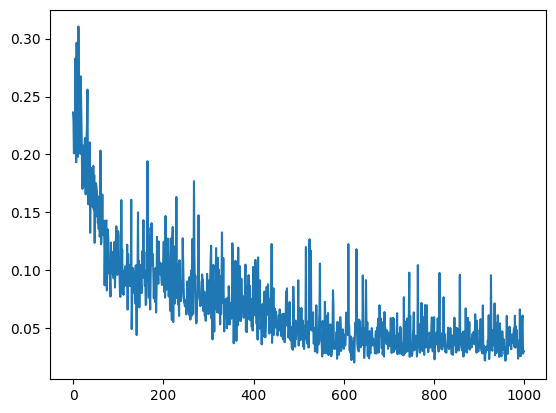

In [329]:
plt.plot(np.arange(len(ofm.metrics["loss"])), ofm.metrics["loss"])

<Axes: ylabel='Density'>

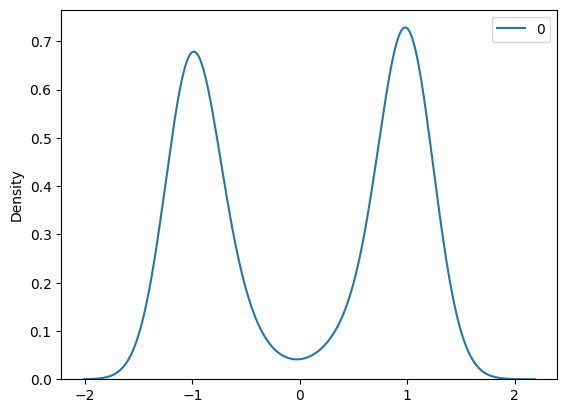

In [330]:
res,_ = ofm.transport(source)
sns.kdeplot(res[0,...])

In [331]:
solution = diffrax.diffeqsolve(
                    diffrax.ODETerm(lambda t,y,args: ofm.state_mlp.apply_fn({"params":ofm.state_mlp.params}, t=t, x=y)),
                    diffrax.Tsit5(),
                    t0=0,
                    t1=1,
                    dt0=None,
                    y0=source, # here we swap source and noise
                    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                    saveat=diffrax.SaveAt(ts=ts),
                    )

In [340]:
inds = jax.random.choice(jax.random.PRNGKey(0), jnp.arange(len(solution.ys)), (30,))
tracks = solution.ys[:,inds,0]

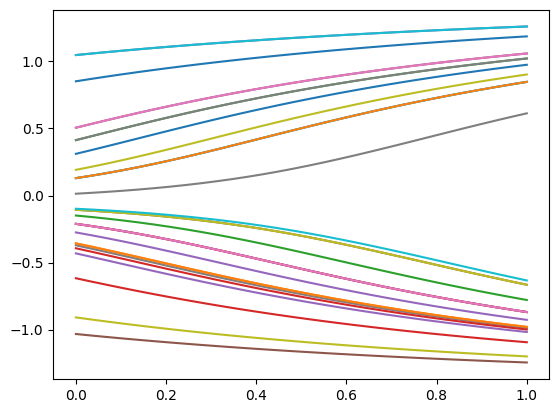

In [341]:
plt.plot(ts, tracks)
plt.show()

In [342]:
t_vec = ts[1:] - ts[:-1]
t_vector = np.tile(t_vec[:, None], (1, tracks.shape[-1]))
y_vector = tracks[1:, ...] - tracks[:-1,...]
t_augmented = np.tile(ts[:, None], (1, tracks.shape[-1]))[:-1, ...]

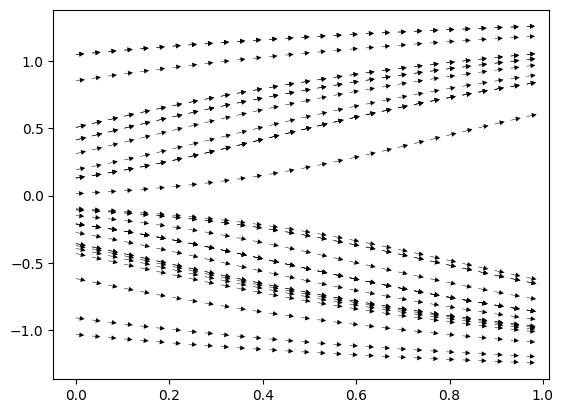

In [343]:
plt.quiver(t_augmented, tracks[:-1], t_vector, y_vector, width=1e-3, headwidth=10, headlength=10, headaxislength=10, angles="xy")

In [75]:
source_repeat = jnp.ones((1,)) * -2
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const, _ = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

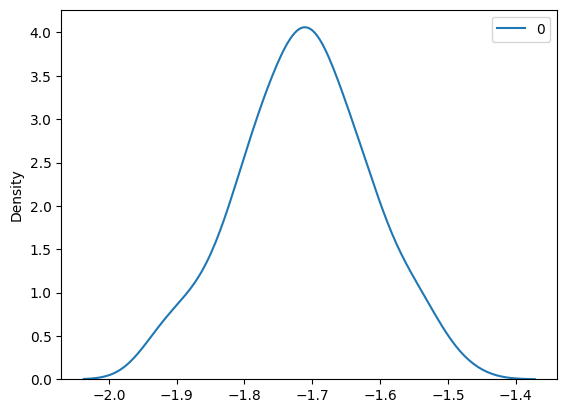

In [76]:
sns.kdeplot(res_const[0,...])

In [36]:
source_repeat = jnp.ones((1,)) * 0
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const, _ = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

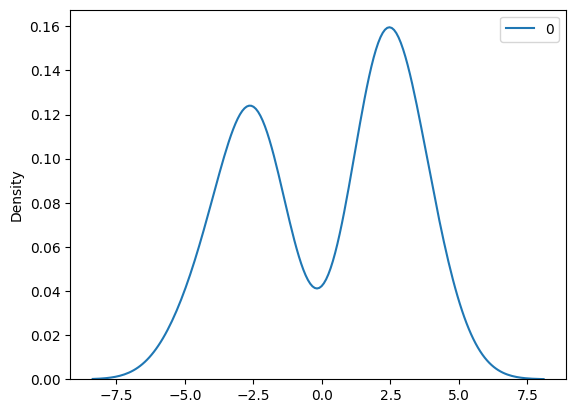

In [37]:
sns.kdeplot(res_const[0,...])

<Axes: ylabel='Density'>

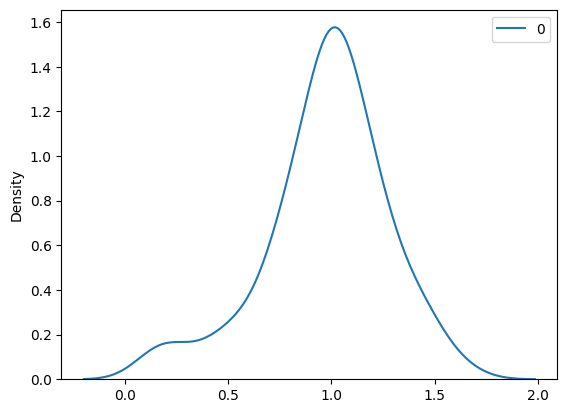

In [40]:
source_repeat = jnp.ones((1,)) * 0.5
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const = otfm.transport(source_repeat, seed=0)
sns.kdeplot(res_const[0,...])

<Axes: ylabel='Density'>

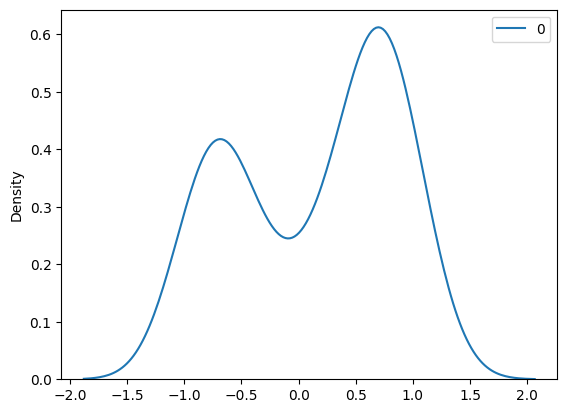

In [41]:
source_repeat = jnp.ones((1,)) * 0.0
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const = otfm.transport(source_repeat, seed=0)
sns.kdeplot(res_const[0,...])

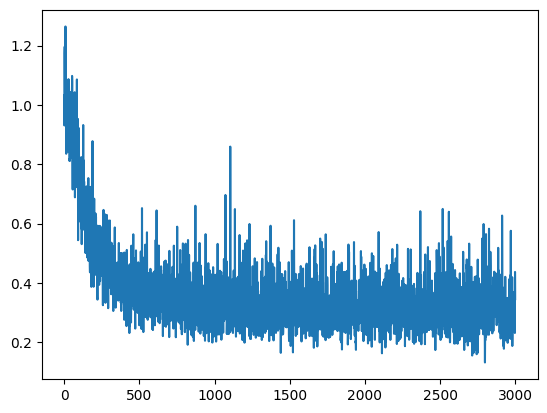

In [40]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])